In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2022-05-01 11:32:06.073487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-05-01 11:32:06.073511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 12

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2022-05-01 11:32:08.346470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 11:32:08.347512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-05-01 11:32:08.347586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-05-01 11:32:08.347649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 12)                132       
                                                                 
Total params: 1,202
Trainable params: 1,202
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
44/47 [===========================>..] - ETA: 0s - loss: 2.4978 - accuracy: 0.0945 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
47/47 [==============================] - 1s 6ms/step - loss: 2.4928 - accuracy: 0.0970 - val_loss: 2.3490 - val_accuracy: 0.1850
Epoch 2/1000
42/47 [=========================>....] - ETA: 0s - loss: 2.3108 - accuracy: 0.1734
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
47/47 [==============================] - 0s 2ms/step - loss: 2.3028 - accuracy: 0.1758 - val_loss: 2.1718 - val_accuracy: 0.2324
Epoch 3/1000
44/47 [===========================>..] - ETA: 0s - loss: 2.1451 - accuracy: 0.2212
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
47/47 [==============================] - 0s 2ms/step - loss: 2.1439 - accuracy: 0.2205 - val_loss: 2.0164 - val_accuracy: 0.2616
Epoch 4/1000
39/47 [=======================>......] - ETA: 0s - loss: 2.0269 - accuracy: 0.2388


In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

16/16 [==============================] - 0s 944us/step - loss: 0.3281 - accuracy: 0.9309


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[8.07817996e-01 6.73157051e-02 1.30115114e-02 1.09635346e-01
 1.63727824e-03 5.68616204e-04 3.06272952e-16 1.33255514e-06
 1.29803243e-11 9.71599457e-06 1.72193580e-07 2.36406208e-06]
0


# Confusion matrix

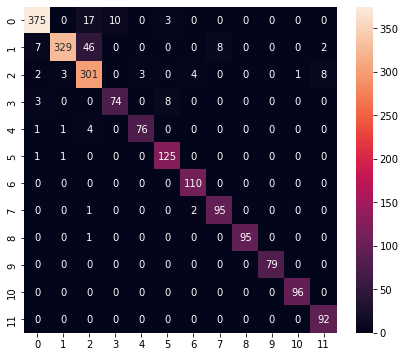

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       405
           1       0.99      0.84      0.91       392
           2       0.81      0.93      0.87       322
           3       0.88      0.87      0.88        85
           4       0.96      0.93      0.94        82
           5       0.92      0.98      0.95       127
           6       0.95      1.00      0.97       110
           7       0.92      0.97      0.95        98
           8       1.00      0.99      0.99        96
           9       1.00      1.00      1.00        79
          10       0.99      1.00      0.99        96
          11       0.90      1.00      0.95        92

    accuracy                           0.93      1984
   macro avg       0.94      0.95      0.95      1984
weighted avg       0.94      0.93      0.93      1984



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2022-05-01 11:32:34.984894: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpm15m3_g3/assets


2022-05-01 11:32:35.675438: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-01 11:32:35.675471: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-01 11:32:35.676173: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpm15m3_g3
2022-05-01 11:32:35.677613: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-01 11:32:35.677644: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpm15m3_g3
2022-05-01 11:32:35.683402: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-01 11:32:35.722990: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpm15m3_g3
2022-05-01 11:32:35.735755: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 59584 m

6768

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 38 µs, sys: 4 µs, total: 42 µs
Wall time: 47.4 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.07817996e-01 6.73157275e-02 1.30115291e-02 1.09635316e-01
 1.63728127e-03 5.68615971e-04 3.06271735e-16 1.33255367e-06
 1.29803486e-11 9.71602185e-06 1.72193737e-07 2.36405776e-06]
0
